In [1]:
plt.style.use('bmh')

### Read dataset and explore features
- we considering the left dataset, because of the following reasons:
    - inner dataset is not enough when we want to understand all locations of the vehicle no matter with sensor measurement or not
    - right and outer datasets consists of a lot of nulls - we don't need sensor measures not binded to any vehicle

In [2]:
df = pd.read_csv('data/left.csv')
print(df.shape)
df[:3]

(831560, 43)


,pkId,fkLinkSerialId,timestamp,speed,acceleration,heading,direction,msla,lat,long,tsReceived,dt,sunrise,sunset,temp,feels_like,pressure,humidity,dew_point,uvi,clouds,visibility,wind_speed,wind_gust,wind_deg,rain,snow,weatherid,place_type,accuracy,place_name,relevance,text,place,region,locality,neighborhood,postcode,country,fkReadingsId,fkSensorSerialId,measurement,value
0,2595649,0X0004BFD0379C,2022-05-07 07:39:00,0,1,0,N,45,-33.23,150.96,2022-05-07 07:39:00,2022-05-07 07:30:33,2022-05-06 16:33:48,2022-05-07 03:11:39,8.17,7.37,1024,70,NaN,NaN,94,10000,1.68,3.55,322,NaN,NaN,804,locality,NaN,"St Albans, New South Wales, Australia",1.00,St Albans,NaN,AU-NSW,NaN,NaN,NaN,au,NaN,NaN,NaN,NaN
1,2595650,0X0004BFD0379C,2022-05-07 07:39:18,0,1,0,N,51,-33.23,150.96,2022-05-07 07:39:18,2022-05-07 07:30:33,2022-05-06 16:33:48,2022-05-07 03:11:39,8.17,7.37,1024,70,NaN,NaN,94,10000,1.68,3.55,322,NaN,NaN,804,locality,NaN,"St Albans, New South Wales, Australia",1.00,St Albans,NaN,AU-NSW,NaN,NaN,NaN,au,NaN,NaN,NaN,NaN
2,2595651,0X0004BFD0379C,2022-05-07 07:39:36,0,1,0,N,58,-33.23,150.96,2022-05-07 07:39:36,2022-05-07 07:30:33,2022-05-06 16:33:48,2022-05-07 03:11:39,8.17,7.37,1024,70,NaN,NaN,94,10000,1.68,3.55,322,NaN,NaN,804,locality,NaN,"St Albans, New South Wales, Australia",1.00,St Albans,NaN,AU-NSW,NaN,NaN,NaN,au,NaN,NaN,NaN,NaN


In [3]:
df.nunique().reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
index,pkId,fkLinkSerialId,timestamp,speed,acceleration,heading,direction,msla,lat,long,tsReceived,dt,sunrise,sunset,temp,feels_like,pressure,humidity,dew_point,uvi,clouds,visibility,wind_speed,wind_gust,wind_deg,rain,snow,weatherid,place_type,accuracy,place_name,relevance,text,place,region,locality,neighborhood,postcode,country,fkReadingsId,fkSensorSerialId,measurement,value
0,550637,10,541602,123,1,360,1,568,93976,120372,541608,90023,55718,53740,4757,5781,103,86,0,0,101,3622,1109,1936,361,358,265,22,5,4,23644,1,3208,718,15,388,343,3515,5,124249,42,2,10166


In [4]:
# remove constants
feats_del = ['acceleration','direction','dew_point','uvi','relevance']
for f in feats_del:
    print(df[f].unique())
    del df[f]

[1]
['N']
[nan]
[nan]
[1.]


In [5]:
# dates convertion
feats = ['timestamp','tsReceived','dt','sunrise','sunset']

df['timestamp_day'] = df['timestamp'].str[:10]
df['timestamp_month'] = df['timestamp'].str[:7]

for f in feats:
    df[f] = pd.to_datetime(df[f])
    
df['ts_month'] = df['timestamp'].dt.month
df['ts_hour']  = df['timestamp'].dt.hour

In [6]:
dict_season = {
    1: '0_winter',
    2: '0_winter',
    3: '2_spring',
    4: '2_spring',
    5: '2_spring',
    6: '3_summer',
    7: '3_summer',
    8: '3_summer',
    9:  '1_autumn',
    10: '1_autumn',
    11: '1_autumn',
    12: '0_winter',   
}
df['ts_season'] = df.ts_month.map(dict_season)

In [7]:
df['ts_daypart'] = pd.cut(df.ts_hour, [-1,5,11,17,24], labels = ['1_night','2_morning','3_afternoon','4_evening']).astype(str)
df.groupby('ts_daypart')['ts_hour'].agg([min,max])

,min,max
ts_daypart,,
1_night,0,5
2_morning,6,11
3_afternoon,12,17
4_evening,18,23


In [8]:
# received and operation - difference
x = (df[feats[1]] - df[feats[0]]).dt.total_seconds()
x.describe()

count   831,560.00
mean          0.01
std           0.14
min           0.00
25%           0.00
50%           0.00
75%           0.00
max          41.00
dtype: float64

In [9]:
# operation and weather - difference
x = (df[feats[0]] - df[feats[2]]).dt.total_seconds()/60
x.describe()

count   831,560.00
mean          3.58
std           3.22
min          -1.08
25%           0.37
50%           2.93
75%           6.27
max          14.73
dtype: float64

### Sensor readings dataset

In [10]:
# Let's create separate sensors dataset
feats1 = ['pkId','country','fkLinkSerialId','timestamp','timestamp_month']
feats2 = ['fkReadingsId','fkSensorSerialId','measurement','value']
df_sensor = df[feats1+feats2]
print(df_sensor.shape)
df_sensor = df_sensor[df_sensor.value.notnull()]
print(df_sensor.shape)
df_sensor[:5]

(831560, 9)
(400411, 9)


,pkId,country,fkLinkSerialId,timestamp,timestamp_month,fkReadingsId,fkSensorSerialId,measurement,value
6,2595655,au,0X0004BFD0379C,2022-05-07 07:40:48,2022-05,"2,595,655.00",0XC07A1A,temperature,17.17
7,2595655,au,0X0004BFD0379C,2022-05-07 07:40:48,2022-05,"2,595,655.00",0XC07A1A,humidity,45.44
9,2595657,au,0X0004BFD0379C,2022-05-07 07:41:24,2022-05,"2,595,657.00",0XC07BAE,temperature,17.55
10,2595657,au,0X0004BFD0379C,2022-05-07 07:41:24,2022-05,"2,595,657.00",0XC07BAE,humidity,44.66
18,2595665,au,0X0004BFD0379C,2022-05-07 07:43:49,2022-05,"2,595,665.00",0XC07A1A,temperature,17.09


In [11]:
df_sensor.fkLinkSerialId.value_counts()

0XB827EBF7489B    214729
0XB827EB3B7400    123847
0X0004BFC0754C     25132
0X0004BFD0379C     21974
0X0004BFD036AA      7915
0X0004BFC0752C      4566
0X0004BFC07537      2216
0X0004BFC07541        28
0X0004BFD036B9         4
Name: fkLinkSerialId, dtype: int64

0X0004BFD0379C


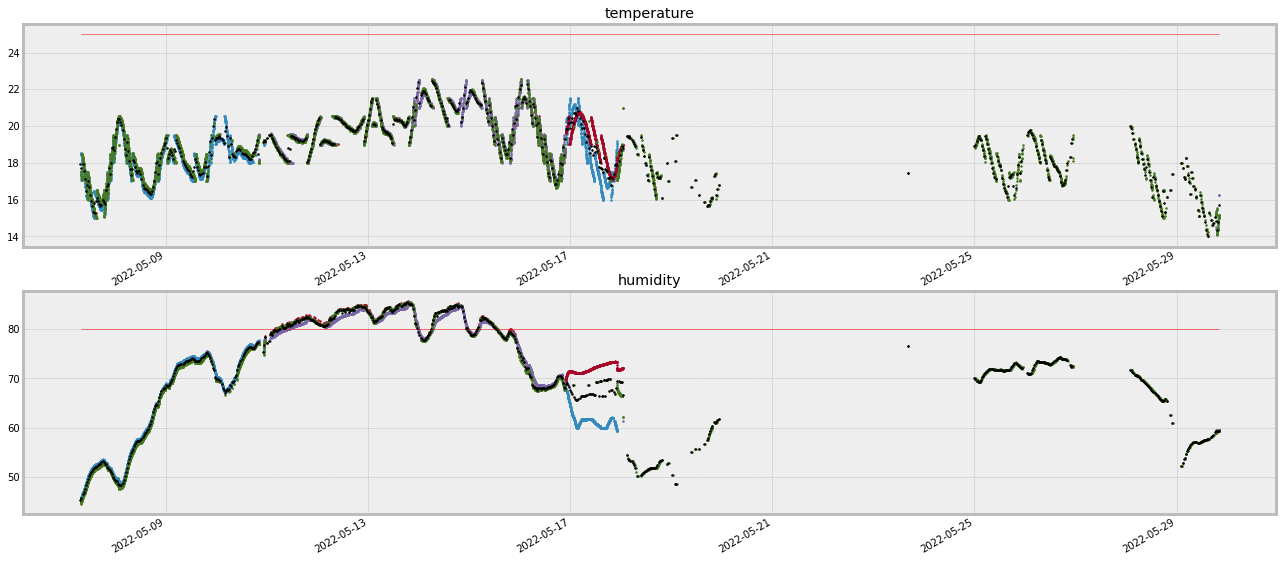

0X0004BFD036AA


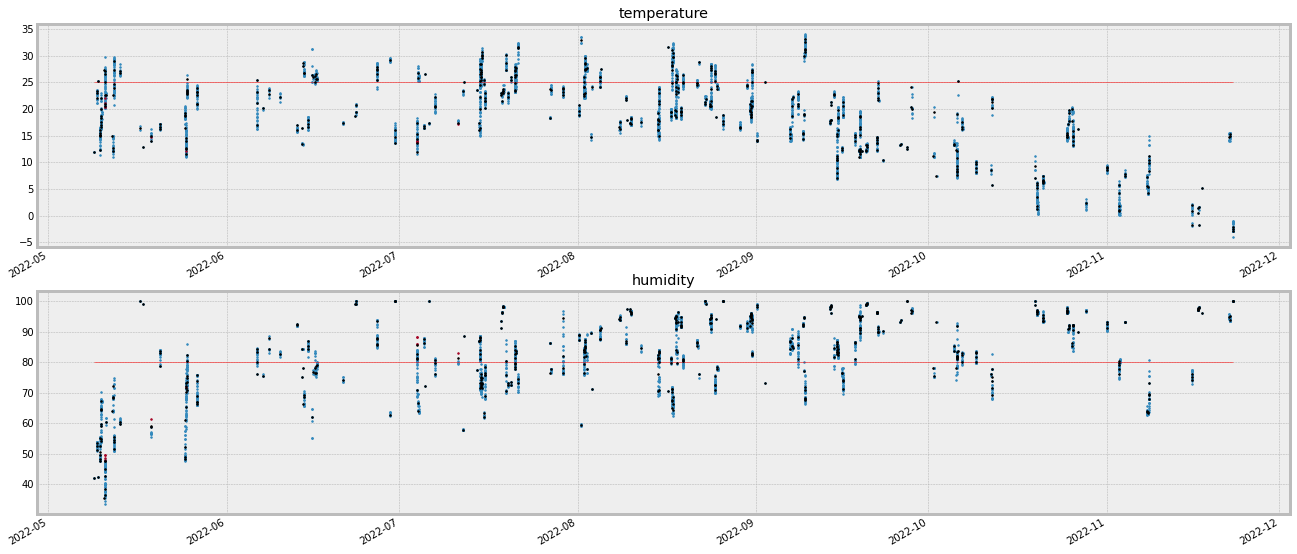

0XB827EBF7489B


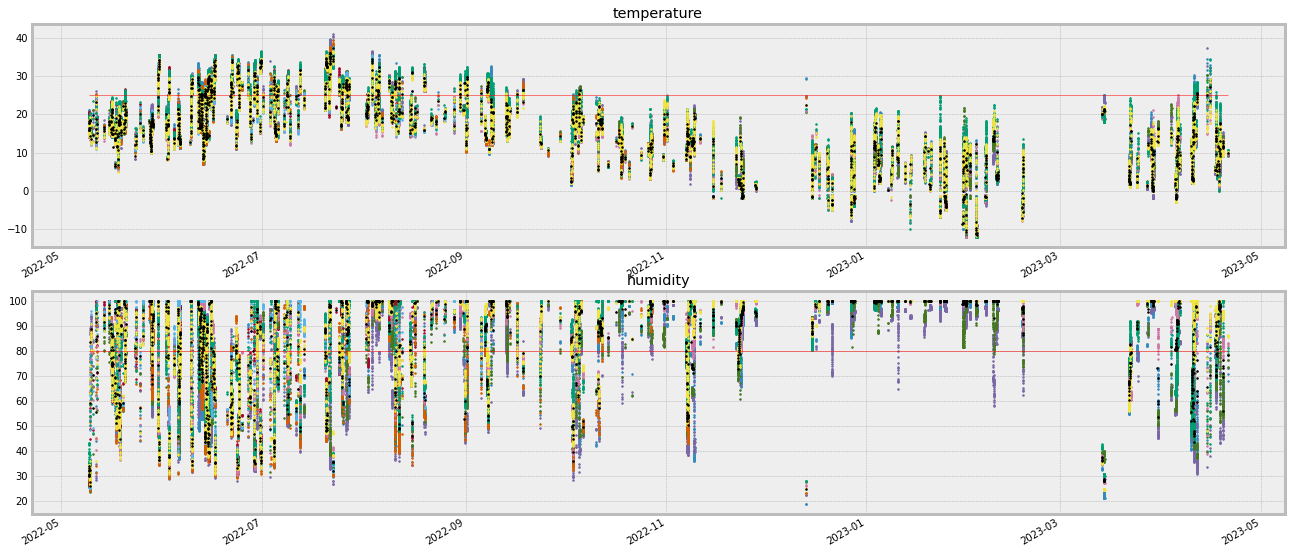

0XB827EB3B7400


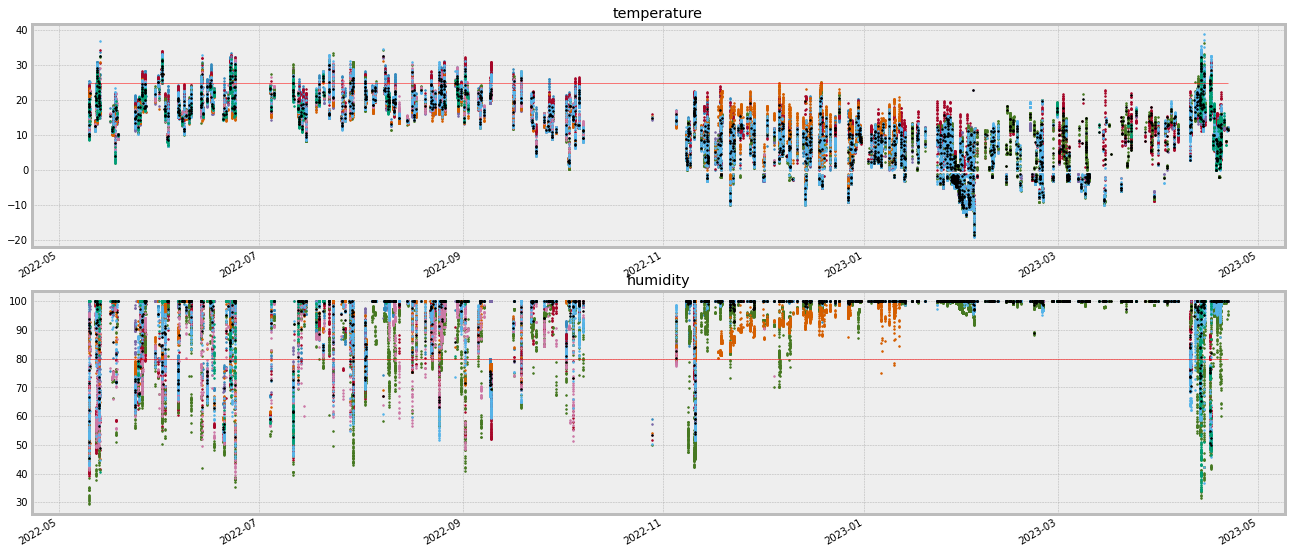

0X0004BFC0754C


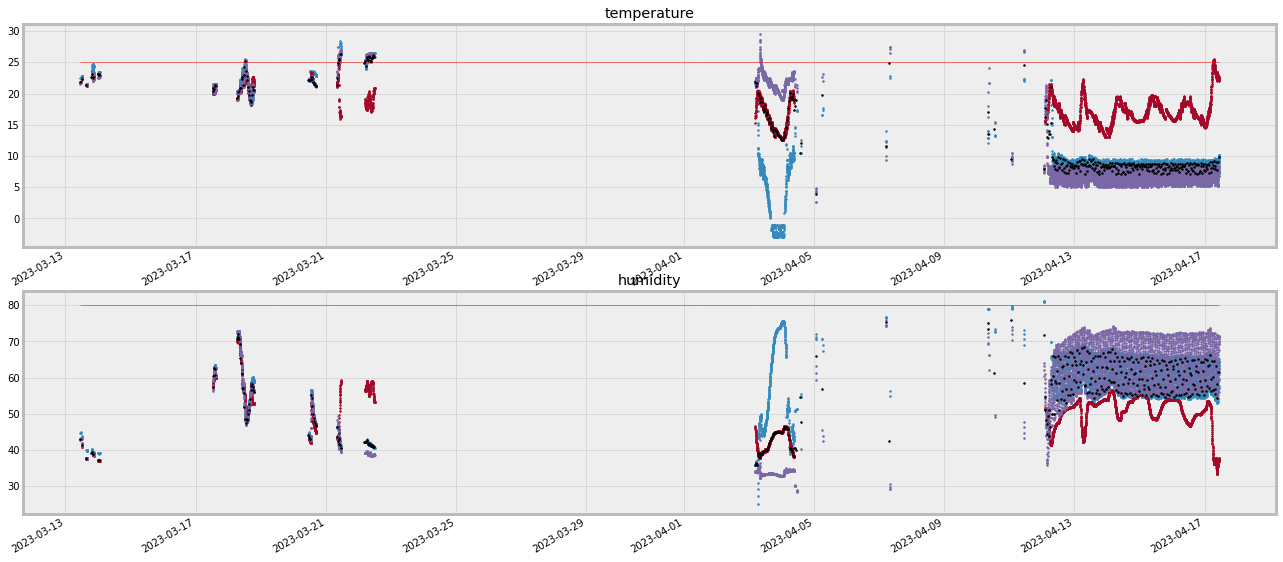

0X0004BFC07537


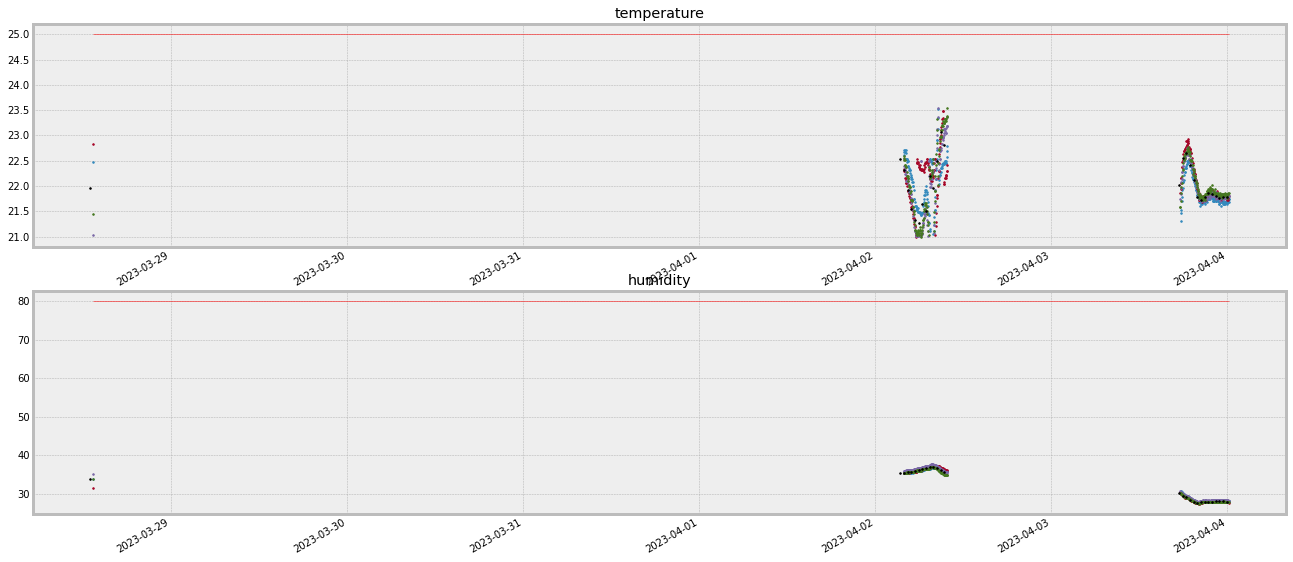

0X0004BFC0752C


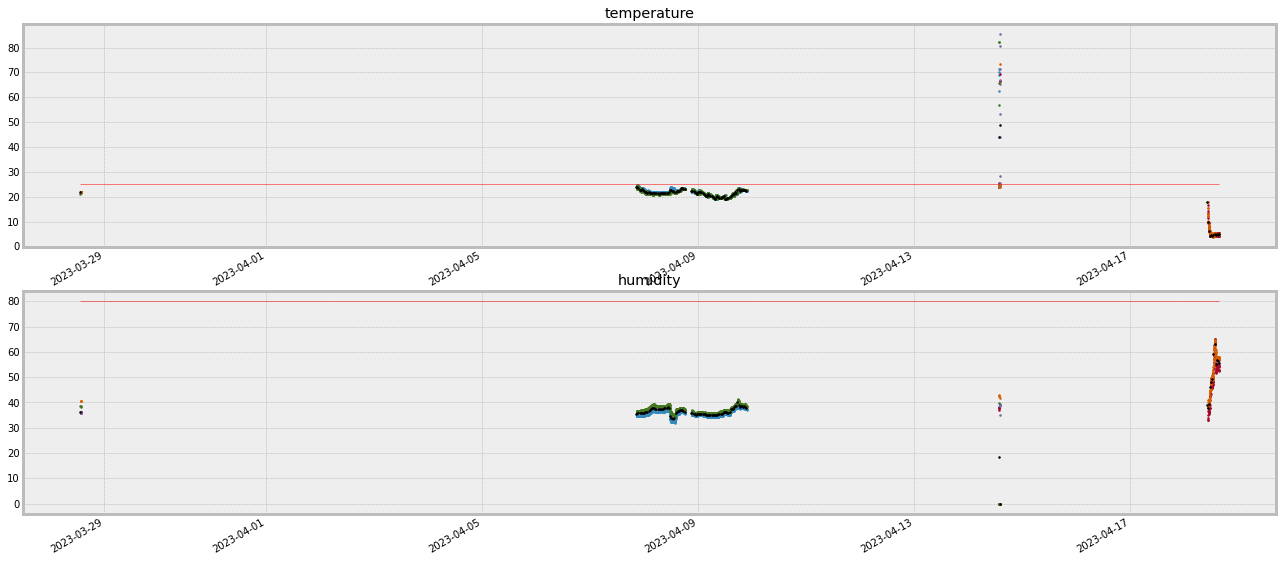

0X0004BFC07541


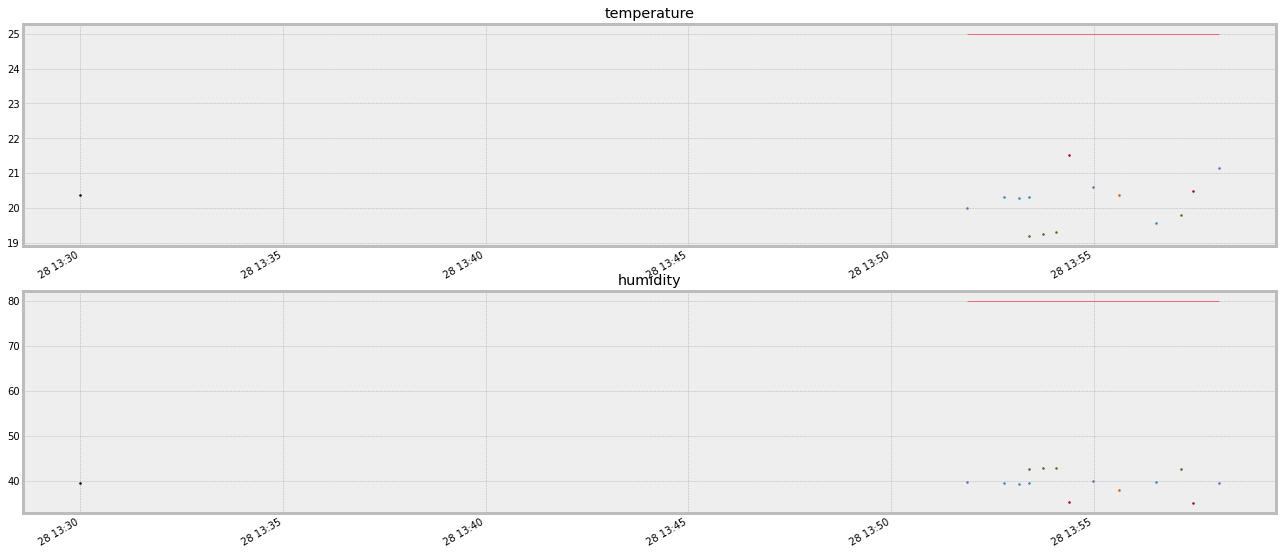

0X0004BFD036B9


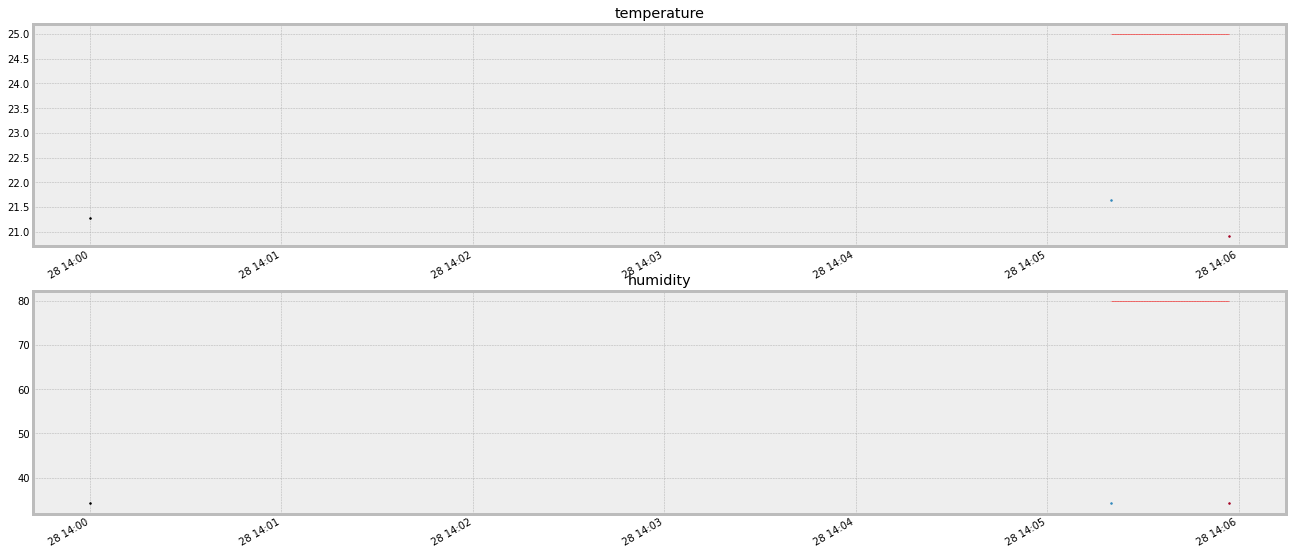

<Figure size 432x288 with 0 Axes>

In [12]:
# plot all points by the vehicle
for t1 in df_sensor.fkLinkSerialId.unique():
    f1 = df_sensor.fkLinkSerialId == t1
    print(t1)
    _,ax = plt.subplots(2,1, figsize = (20,10))
    for i,t in enumerate(['temperature', 'humidity']):
        f2 = df_sensor.measurement == t
        x = df_sensor[f1&f2].groupby(['timestamp','fkSensorSerialId']).value.min().unstack()
        _ = x.plot(ax = ax[i],title = t, xlabel = '', style = '.', markersize = 3, legend = False)
        _.hlines(80 if t == 'humidity' else 25, xmin = x.index.min(), xmax = x.index.max(), color = 'red', linewidth = 0.5)
        
        x = x.resample('30min').median()
        x['median'] = x.median(axis = 1)
        x = x[['median']]
        _ = x.plot(ax = ax[i],title = t, xlabel = '', style = '.', linewidth = 2, markersize = 3, legend = False, color = 'black')
        
    plt.show()
plt.tight_layout()

0X0004BFD0379C


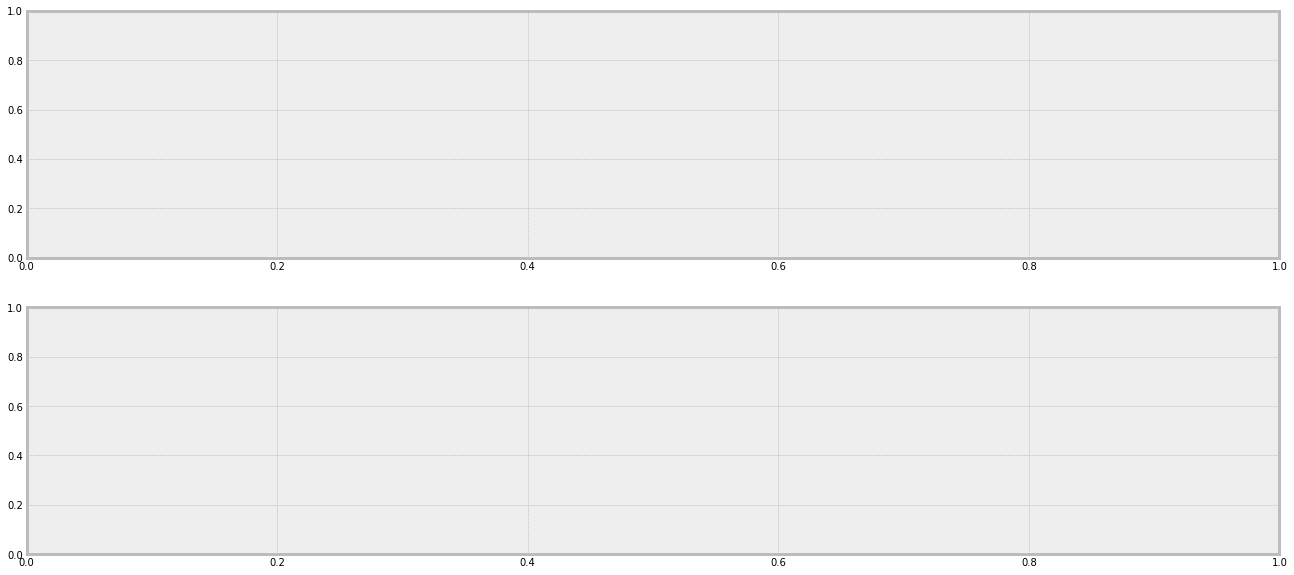

0X0004BFD036AA


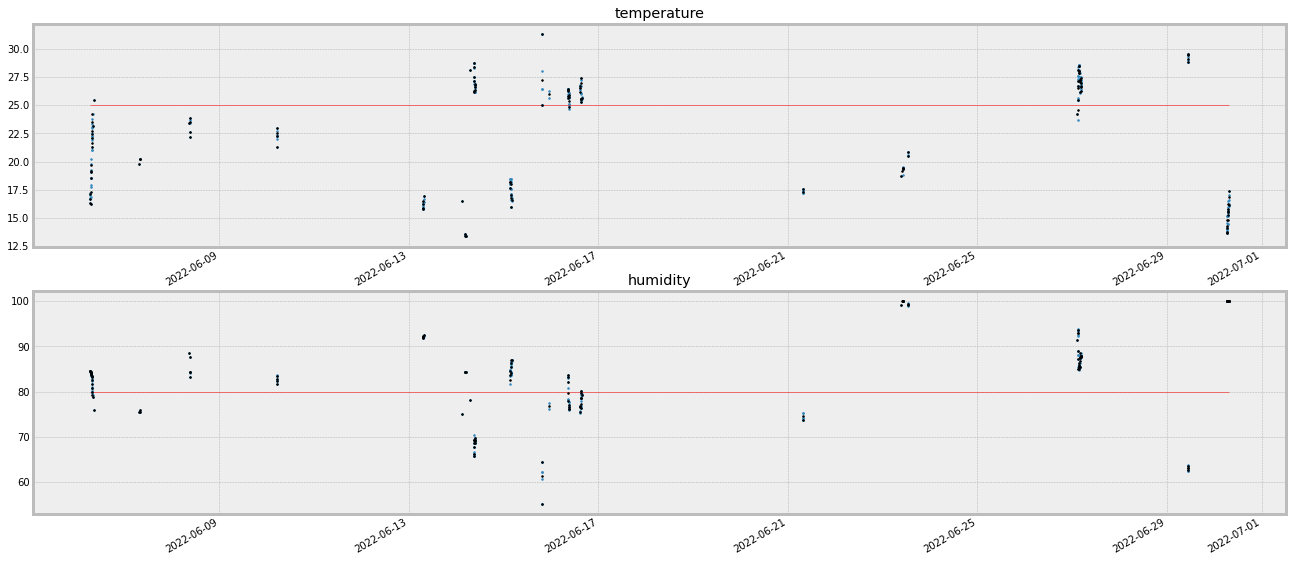

0XB827EBF7489B


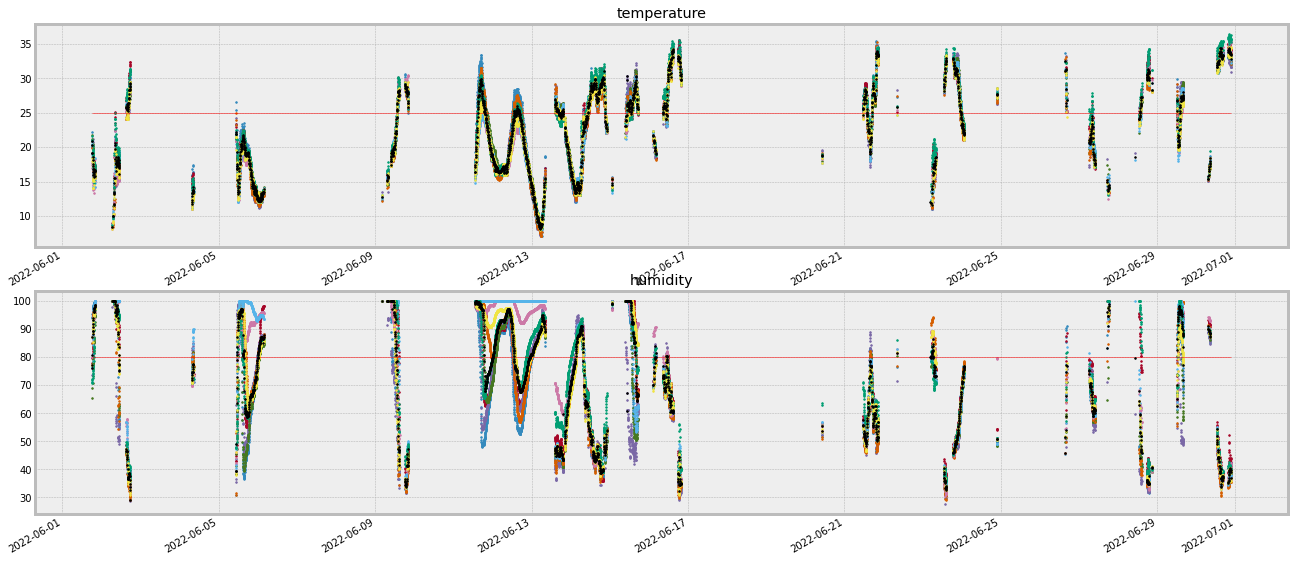

0XB827EB3B7400


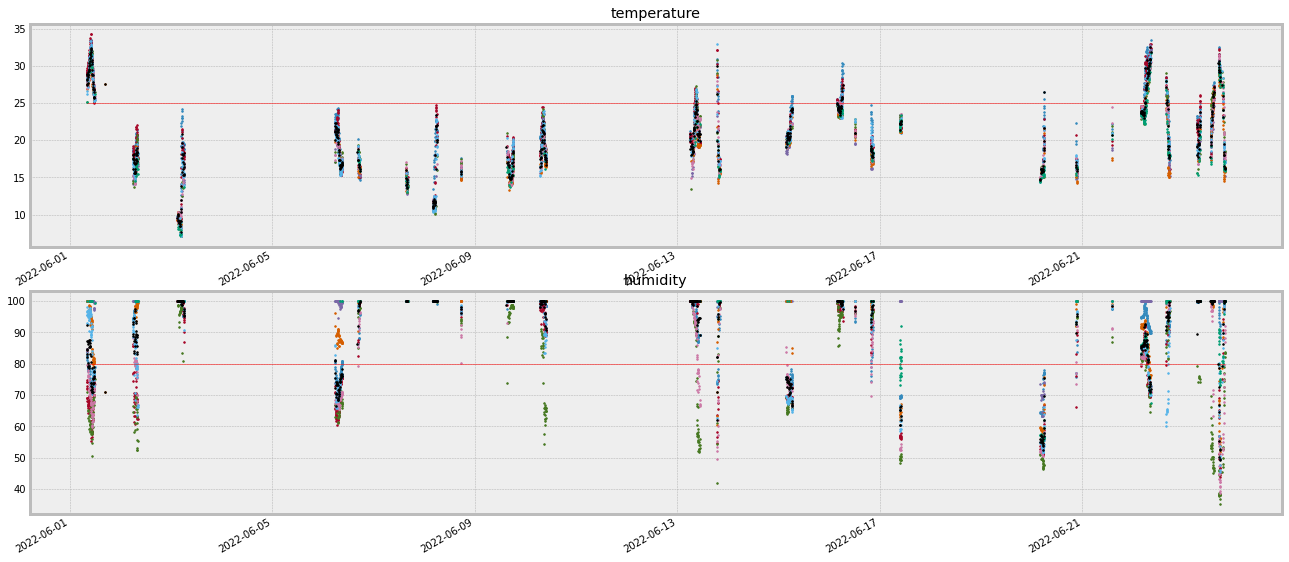

0X0004BFC0754C


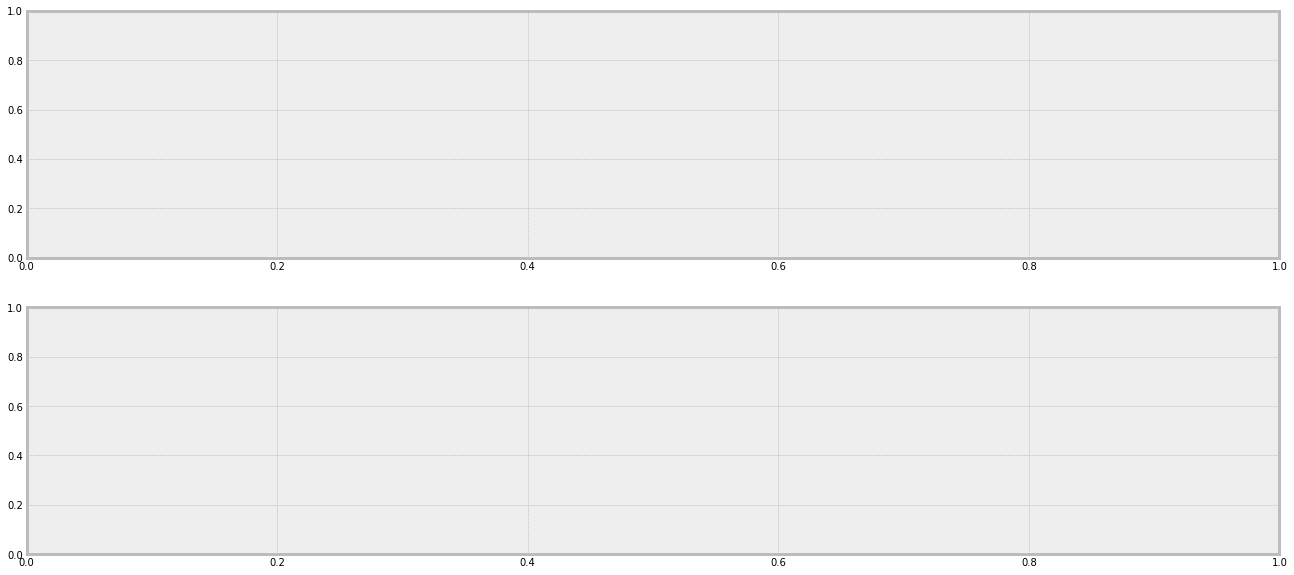

0X0004BFC07537


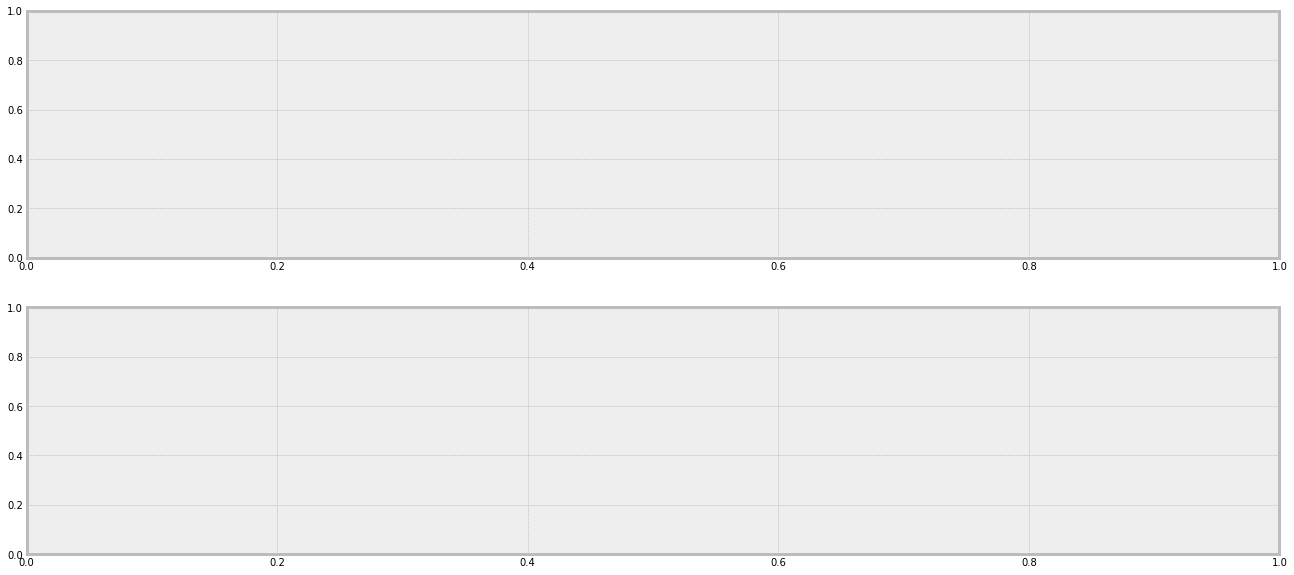

0X0004BFC0752C


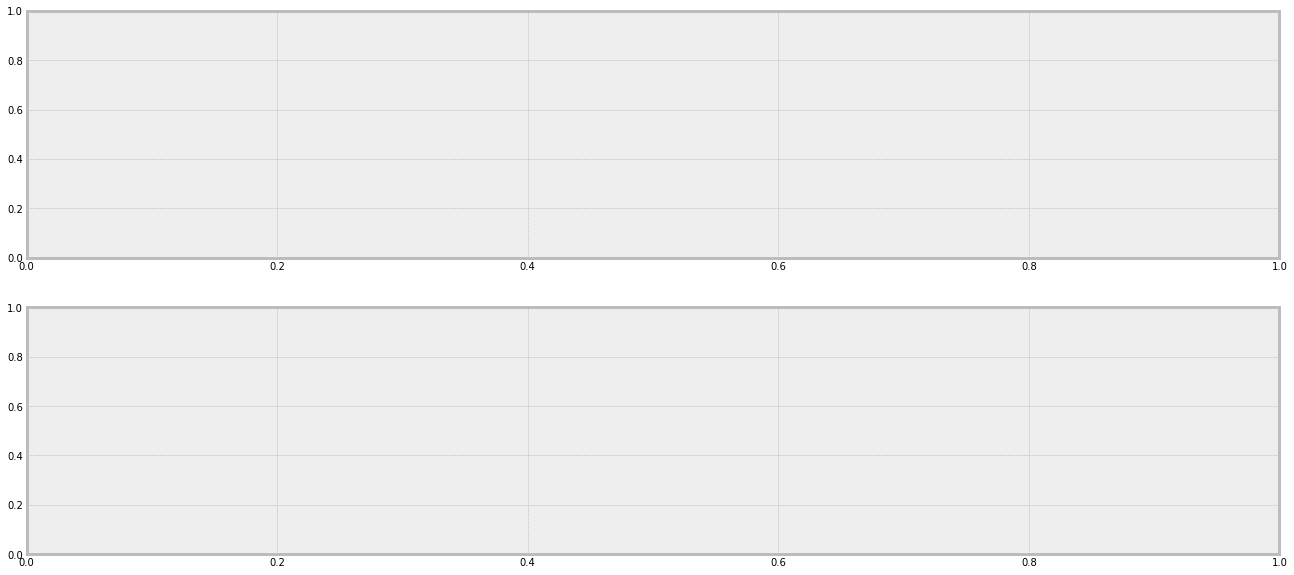

0X0004BFC07541


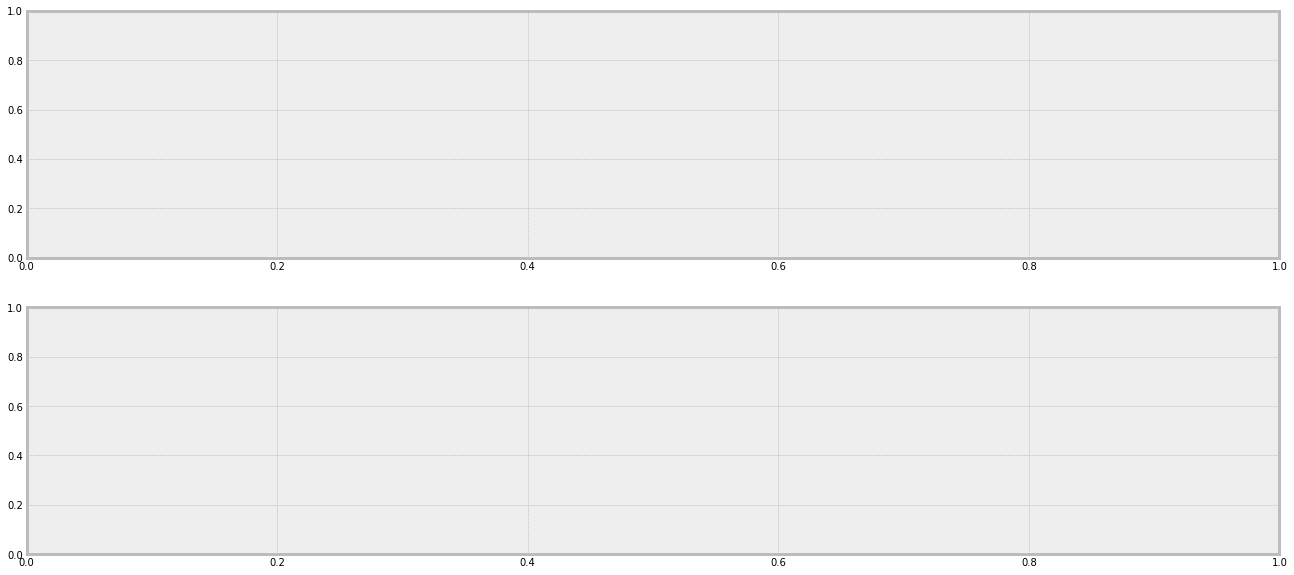

0X0004BFD036B9


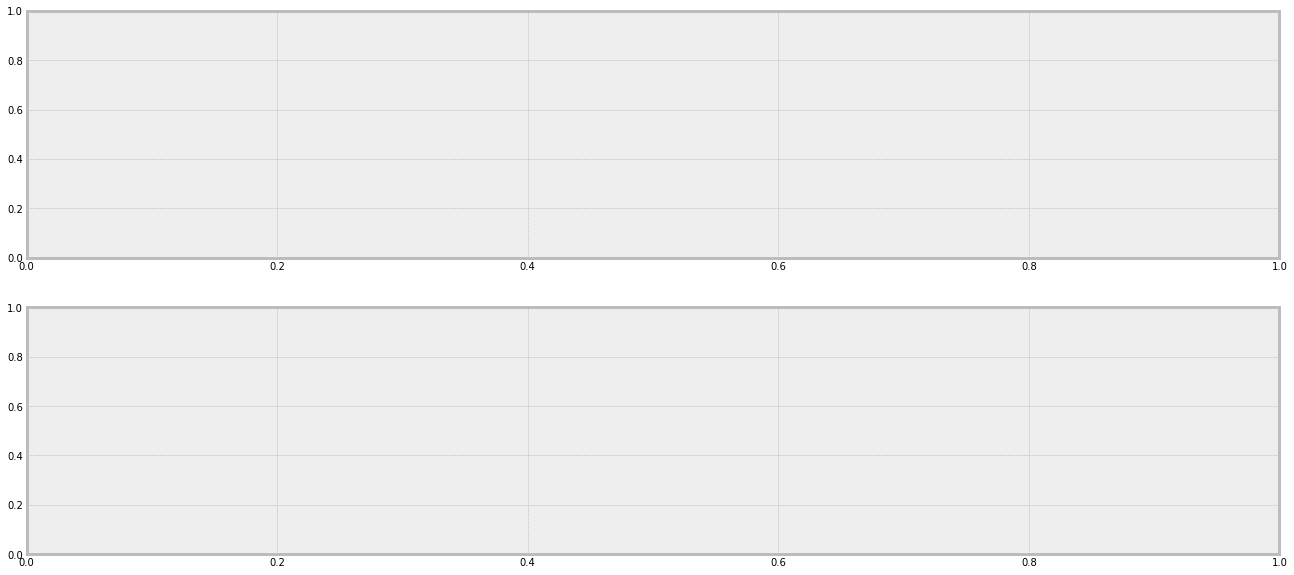

<Figure size 432x288 with 0 Axes>

In [13]:
# plot all points by the vehicle for one month
for t1 in df_sensor.fkLinkSerialId.unique():
    f1 = df_sensor.fkLinkSerialId == t1
    print(t1)
    _,ax = plt.subplots(2,1, figsize = (20,10))
    for i,t in enumerate(['temperature', 'humidity']):
        f2 = df_sensor.measurement == t
        f3 = df_sensor.timestamp_month == '2022-06'
        if df_sensor[f1&f2&f3].shape[0] == 0:
            continue
        x = df_sensor[f1&f2&f3].groupby(['timestamp','fkSensorSerialId']).value.min().unstack()
        _ = x.plot(ax = ax[i],title = t, xlabel = '', style = '.', markersize = 3, legend = False)
        _.hlines(80 if t == 'humidity' else 25, xmin = x.index.min(), xmax = x.index.max(), color = 'red', linewidth = 0.5)
        
        x = x.resample('5min').median()
        x['median'] = x.median(axis = 1)
        x = x[['median']]
        _ = x.plot(ax = ax[i],title = t, xlabel = '', style = '.', linewidth = 2, markersize = 3, legend = False, color = 'black')
        
    plt.show()
plt.tight_layout()

In [14]:
# create targets (w/o fkSensorSerialId)
df_trg = df_sensor.groupby(['pkId','measurement']).value.median().unstack().reset_index().rename(
    columns = {'humidity': 'target_humidity', 'temperature': 'target_temperature'}
)
print(df_trg.shape,df_trg.nunique())

feat = 'target_humidity'
df_trg[f'{feat}_cat'] = 0
f01 = df_trg[feat] > 80
df_trg.loc[f01, f'{feat}_cat'] = 1

feat = 'target_temperature'
df_trg[f'{feat}_cat'] = 0
f02 = df_trg[feat] > 25
df_trg.loc[f02, f'{feat}_cat'] = 1

df_trg['target_cat'] = 0
df_trg.loc[f01|f02, 'target_cat'] = 1

print(df_trg.shape)
df_trg[:5]

(124249, 3) measurement
pkId                  124249
target_humidity        13991
target_temperature      9669
dtype: int64
(124249, 6)


measurement,pkId,target_humidity,target_temperature,target_humidity_cat,target_temperature_cat,target_cat
0,2595655,45.44,17.17,0,0,0
1,2595657,44.66,17.55,0,0,0
2,2595665,45.53,17.09,0,0,0
3,2595667,44.74,17.48,0,0,0
4,2595675,45.62,18.55,0,0,0


In [15]:
# drop duplicates from initial dataset and merge with targets
print(df.shape)
for f in feats2:
    del df[f]
    
df.drop_duplicates(inplace = True)
print(df.shape)
print(df.pkId.nunique())
df[:3]

(831560, 44)
(550637, 40)
550637


,pkId,fkLinkSerialId,timestamp,speed,heading,msla,lat,long,tsReceived,dt,sunrise,sunset,temp,feels_like,pressure,humidity,clouds,visibility,wind_speed,wind_gust,wind_deg,rain,snow,weatherid,place_type,accuracy,place_name,text,place,region,locality,neighborhood,postcode,country,timestamp_day,timestamp_month,ts_month,ts_hour,ts_season,ts_daypart
0,2595649,0X0004BFD0379C,2022-05-07 07:39:00,0,0,45,-33.23,150.96,2022-05-07 07:39:00,2022-05-07 07:30:33,2022-05-06 16:33:48,2022-05-07 03:11:39,8.17,7.37,1024,70,94,10000,1.68,3.55,322,NaN,NaN,804,locality,NaN,"St Albans, New South Wales, Australia",St Albans,NaN,AU-NSW,NaN,NaN,NaN,au,2022-05-07,2022-05,5,7,2_spring,2_morning
1,2595650,0X0004BFD0379C,2022-05-07 07:39:18,0,0,51,-33.23,150.96,2022-05-07 07:39:18,2022-05-07 07:30:33,2022-05-06 16:33:48,2022-05-07 03:11:39,8.17,7.37,1024,70,94,10000,1.68,3.55,322,NaN,NaN,804,locality,NaN,"St Albans, New South Wales, Australia",St Albans,NaN,AU-NSW,NaN,NaN,NaN,au,2022-05-07,2022-05,5,7,2_spring,2_morning
2,2595651,0X0004BFD0379C,2022-05-07 07:39:36,0,0,58,-33.23,150.96,2022-05-07 07:39:36,2022-05-07 07:30:33,2022-05-06 16:33:48,2022-05-07 03:11:39,8.17,7.37,1024,70,94,10000,1.68,3.55,322,NaN,NaN,804,locality,NaN,"St Albans, New South Wales, Australia",St Albans,NaN,AU-NSW,NaN,NaN,NaN,au,2022-05-07,2022-05,5,7,2_spring,2_morning


In [16]:
# merge
df = df.merge(df_trg, on = 'pkId', how = 'left')
print(df.shape)
df[:3]

(550637, 45)


,pkId,fkLinkSerialId,timestamp,speed,heading,msla,lat,long,tsReceived,dt,sunrise,sunset,temp,feels_like,pressure,humidity,clouds,visibility,wind_speed,wind_gust,wind_deg,rain,snow,weatherid,place_type,accuracy,place_name,text,place,region,locality,neighborhood,postcode,country,timestamp_day,timestamp_month,ts_month,ts_hour,ts_season,ts_daypart,target_humidity,target_temperature,target_humidity_cat,target_temperature_cat,target_cat
0,2595649,0X0004BFD0379C,2022-05-07 07:39:00,0,0,45,-33.23,150.96,2022-05-07 07:39:00,2022-05-07 07:30:33,2022-05-06 16:33:48,2022-05-07 03:11:39,8.17,7.37,1024,70,94,10000,1.68,3.55,322,NaN,NaN,804,locality,NaN,"St Albans, New South Wales, Australia",St Albans,NaN,AU-NSW,NaN,NaN,NaN,au,2022-05-07,2022-05,5,7,2_spring,2_morning,NaN,NaN,NaN,NaN,NaN
1,2595650,0X0004BFD0379C,2022-05-07 07:39:18,0,0,51,-33.23,150.96,2022-05-07 07:39:18,2022-05-07 07:30:33,2022-05-06 16:33:48,2022-05-07 03:11:39,8.17,7.37,1024,70,94,10000,1.68,3.55,322,NaN,NaN,804,locality,NaN,"St Albans, New South Wales, Australia",St Albans,NaN,AU-NSW,NaN,NaN,NaN,au,2022-05-07,2022-05,5,7,2_spring,2_morning,NaN,NaN,NaN,NaN,NaN
2,2595651,0X0004BFD0379C,2022-05-07 07:39:36,0,0,58,-33.23,150.96,2022-05-07 07:39:36,2022-05-07 07:30:33,2022-05-06 16:33:48,2022-05-07 03:11:39,8.17,7.37,1024,70,94,10000,1.68,3.55,322,NaN,NaN,804,locality,NaN,"St Albans, New South Wales, Australia",St Albans,NaN,AU-NSW,NaN,NaN,NaN,au,2022-05-07,2022-05,5,7,2_spring,2_morning,NaN,NaN,NaN,NaN,NaN


### Vehicles statistics and heatmaps

In [17]:
# vehicles statistics
df_gr = df.groupby(['fkLinkSerialId']).agg({
    'country': lambda x: set(x),
    'target_temperature': [len, lambda x: x.count(), ],
    'timestamp': [lambda x: max(x) - min(x)],
}).reset_index()
df_gr.iloc[:,-1] = df_gr.iloc[:,-1].dt.total_seconds()/(3600*24)
df_gr.columns = ['fkLinkSerialId','countries','number of rows','number of targets','days of history']
df_gr

,fkLinkSerialId,countries,number of rows,number of targets,days of history
0,0X0004BFC0752C,{ca},10170,2069,21.08
1,0X0004BFC07537,"{us, ca}",2468,1055,6.46
2,0X0004BFC07541,{ca},73,13,0.02
3,0X0004BFC0754C,"{dk, ca, ie}",40067,11032,34.99
4,0X0004BFD036AA,"{us, ca}",49344,3940,262.36
5,0X0004BFD036AD,{au},58773,0,50.57
6,0X0004BFD036B9,{ca},9218,2,20.10
7,0X0004BFD0379C,{au},106458,10394,22.53
8,0XB827EB3B7400,"{us, ca}",144042,34531,346.50
9,0XB827EBF7489B,"{us, ca}",130024,58496,346.59


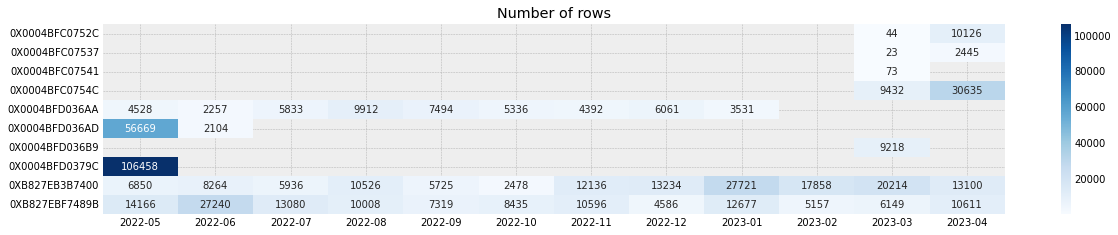

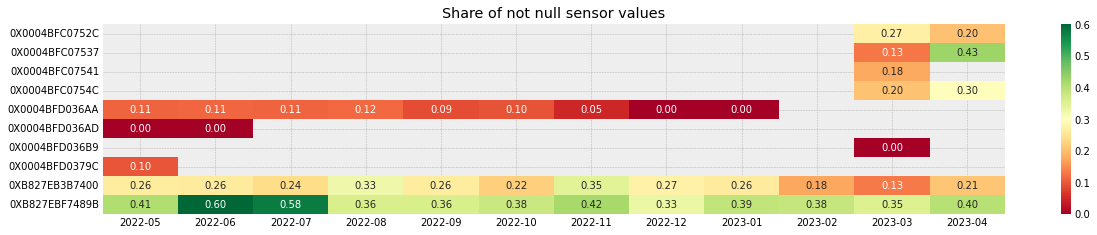

In [18]:
df_corr = df.groupby(['fkLinkSerialId','timestamp_month']).target_temperature.size().unstack()
_, ax = plt.subplots(1,1, figsize = (18,3.5))
_ = sns.heatmap(df_corr, ax = ax, cmap = 'Blues', annot = True, fmt = '.0f', annot_kws={"size": 10})
_ = ax.set_title('Number of rows')
_ = ax.set_xlabel('')
_ = ax.set_ylabel('')

df_corr = df.groupby(['fkLinkSerialId','timestamp_month']).target_temperature.agg(lambda x: x.count()/len(x)).unstack()
_, ax = plt.subplots(1,1, figsize = (18,3.5))
_ = sns.heatmap(df_corr, ax = ax, cmap = 'RdYlGn', annot = True, fmt = '.2f', annot_kws={"size": 10})
_ = ax.set_title('Share of not null sensor values')
_ = ax.set_xlabel('')
_ = ax.set_ylabel('')

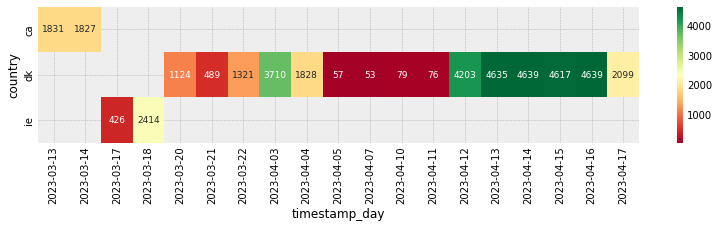

In [19]:
filt = df.fkLinkSerialId == '0X0004BFC0754C'
df_corr = df[filt].groupby(['country','timestamp_day']).size().unstack()

_, ax = plt.subplots(1,1, figsize = (12,2.5))
_ = sns.heatmap(df_corr, ax = ax, cmap = 'RdYlGn', annot = True, fmt = '.0f', annot_kws={"size": 9})

### Region feats explore

In [20]:
feats = ['country','place_type','accuracy', 'text', 'place', 'region', 'locality','neighborhood', 'postcode', 'place_name']
df[feats][:5]

,country,place_type,accuracy,text,place,region,locality,neighborhood,postcode,place_name
0,au,locality,NaN,St Albans,NaN,AU-NSW,NaN,NaN,NaN,"St Albans, New South Wales, Australia"
1,au,locality,NaN,St Albans,NaN,AU-NSW,NaN,NaN,NaN,"St Albans, New South Wales, Australia"
2,au,locality,NaN,St Albans,NaN,AU-NSW,NaN,NaN,NaN,"St Albans, New South Wales, Australia"
3,au,locality,NaN,St Albans,NaN,AU-NSW,NaN,NaN,NaN,"St Albans, New South Wales, Australia"
4,au,locality,NaN,St Albans,NaN,AU-NSW,NaN,NaN,NaN,"St Albans, New South Wales, Australia"


In [21]:
# filled rows counts
df[feats].groupby('country').agg(lambda x: x.notnull().sum())

,place_type,accuracy,text,place,region,locality,neighborhood,postcode,place_name
country,,,,,,,,,
au,165231,50606,165231,43439,165231,50605,0,50606,165231
ca,316857,314233,316857,313892,316004,20951,46644,314002,316857
dk,33569,33569,33569,33569,33569,0,0,33569,33569
ie,2840,0,2840,0,0,0,0,0,2840
us,32140,31785,32140,31894,32021,9113,2818,31755,32140


In [22]:
# filled unique rows counts
df[feats].groupby('country').agg(lambda x: len(x[x.notnull()].unique()))

,place_type,accuracy,text,place,region,locality,neighborhood,postcode,place_name
country,,,,,,,,,
au,2,3,270,24,2,98,0,52,1889
ca,5,4,1771,457,3,179,232,3183,18448
dk,1,3,39,8,2,0,0,9,156
ie,1,0,1,0,0,0,0,0,1
us,4,4,1167,236,8,111,111,274,3150


In [23]:
df[feats].fillna('').groupby(['country','place_type','accuracy']).size().unstack()

accuracy                        parcel      point   rooftop    street
country place_type                                                   
au      address           NaN      NaN  47,789.00    381.00  2,436.00
        locality   114,625.00      NaN        NaN       NaN       NaN
ca      address           NaN    13.00 193,323.00 61,794.00 59,103.00
        locality         1.00      NaN        NaN       NaN       NaN
        place        1,613.00      NaN        NaN       NaN       NaN
        postcode       157.00      NaN        NaN       NaN       NaN
        region         853.00      NaN        NaN       NaN       NaN
dk      address           NaN      NaN      64.00 33,459.00     46.00
ie      region       2,840.00      NaN        NaN       NaN       NaN
us      address           NaN 5,317.00   4,382.00  7,466.00 14,620.00
        locality       127.00      NaN        NaN       NaN       NaN
        place          109.00      NaN        NaN       NaN       NaN
        region         119.00      NaN        NaN       NaN       NaN

In [24]:
df[feats].fillna('').groupby(['country','region']).size().unstack()

region,,AU-NSW,AU-VIC,CA-NB,CA-ON,CA-QC,DK-82,DK-83,US-IA,US-IL,US-IN,US-MI,US-MN,US-NY,US-PA,US-VT
country,,,,,,,,,,,,,,,,
au,NaN,"106,458.00","58,773.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ca,853.00,NaN,NaN,18.00,"260,107.00","55,879.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dk,NaN,NaN,NaN,NaN,NaN,NaN,"32,445.00","1,124.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ie,"2,840.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
us,119.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"10,402.00","3,198.00","3,393.00","11,111.00","1,288.00","2,057.00",531.00,41.00


### Features grouping

In [25]:
feats_geo = ['speed','heading','msla','lat','long']
df[feats_geo].isnull().sum()

speed      0
heading    0
msla       0
lat        0
long       0
dtype: int64

In [26]:
# average values
df_gr = df.groupby('fkLinkSerialId')[feats_geo].agg(np.mean)
df_gr['len'] = df.groupby('fkLinkSerialId').size()
df_gr.reset_index(inplace = True)
display(df_gr)

,fkLinkSerialId,speed,heading,msla,lat,long,len
0,0X0004BFC0752C,0.02,0.12,254.82,43.98,-79.46,10170
1,0X0004BFC07537,0.04,0.59,267.60,44.06,-86.66,2468
2,0X0004BFC07541,0.88,9.52,227.45,43.19,-80.03,73
3,0X0004BFC0754C,0.55,2.99,86.44,54.92,0.78,40067
4,0X0004BFD036AA,42.92,85.30,53.36,45.72,-73.19,49344
5,0X0004BFD036AD,7.42,18.91,70.74,-38.00,145.42,58773
6,0X0004BFD036B9,0.21,1.82,233.88,43.19,-80.03,9218
7,0X0004BFD0379C,0.02,0.20,50.96,-33.23,150.96,106458
8,0XB827EB3B7400,23.43,56.30,323.37,43.41,-80.81,144042
9,0XB827EBF7489B,34.36,73.54,283.40,43.26,-81.73,130024


In [27]:
# vehicles to use for analysis
list_ids = ['0X0004BFD036AA','0XB827EB3B7400','0XB827EBF7489B']
filt = df.fkLinkSerialId.isin(list_ids)
df = df[filt]

In [28]:
df['lat_int']  = df.lat.astype(int)
df['long_int'] = df.long.astype(int)

In [29]:
df.groupby(['lat_int']).lat.agg([min,max]).T

lat_int,40,41,42,43,44,45,46,47
min,40.00,41.00,42.00,43.00,44.00,45.00,46.00,47.00
max,40.66,41.68,42.70,43.72,44.73,45.75,46.77,47.70


In [30]:
df.groupby(['long_int']).long.agg([min,max]).T

long_int,-93,-92,-91,-90,-89,-88,-87,-86,-85,-84,-83,-82,-81,-80,-79,-78,-77,-76,-75,-74,-73,-72,-71,-70,-69,-68
min,-93.38,-93.00,-92.00,-91.00,-90.00,-89.00,-88.00,-87.00,-86.00,-85.00,-84.00,-83.00,-82.00,-81.00,-80.00,-79.00,-78.00,-77.00,-76.00,-75.00,-74.00,-73.00,-72.00,-71.00,-70.00,-69.00
max,-93.00,-92.00,-91.00,-90.00,-89.00,-88.00,-87.00,-86.00,-85.00,-84.00,-83.00,-82.00,-81.00,-80.00,-79.00,-78.00,-77.00,-76.00,-75.00,-74.00,-73.00,-72.00,-71.00,-70.00,-69.00,-68.71


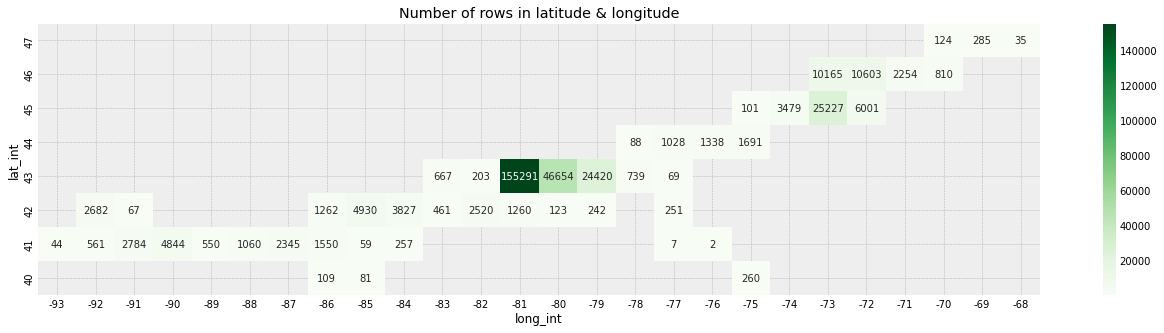

In [31]:
df_corr = df.groupby(['lat_int','long_int']).size().unstack()
df_corr = df_corr.sort_index(ascending = False)
_, ax = plt.subplots(1,1, figsize = (20,5))
_ = sns.heatmap(df_corr, ax = ax, cmap = 'Greens', annot = True, fmt = '.0f', annot_kws={"size": 10})
_ = ax.set_title('Number of rows in latitude & longitude')
# _ = ax.set_xlabel('')
# _ = ax.set_ylabel('')

In [32]:
df['geo_group'] = df.long.map(lambda x: '1.west' if x < -83 else '2.center' if x < -78 else '3.east')
df.groupby('geo_group').long.agg([min,max,len])

,min,max,len
geo_group,,,
1.west,-93.38,-83.00,28140
2.center,-83.00,-78.00,231540
3.east,-78.00,-68.71,63730


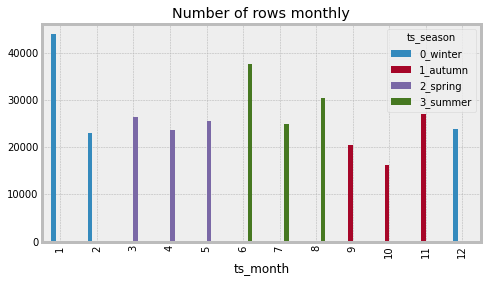

In [33]:
_ = df.groupby(['ts_month','ts_season']).size().unstack().plot(kind = 'bar', figsize = (7,4), title = 'Number of rows monthly')

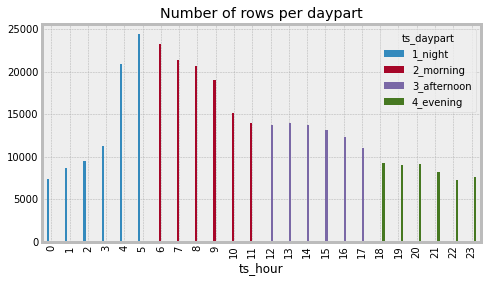

In [34]:
_ = df.groupby(['ts_hour','ts_daypart']).size().unstack().plot(kind = 'bar', figsize = (7,4), title = 'Number of rows per daypart',)

In [35]:
# for s in df.ts_season.unique():
#     f1 = df.ts_season == s
#     print(s)
#     df_corr = df[f1].groupby(['lat_int','long_int']).size().unstack()
#     df_corr = df_corr.sort_index(ascending = False)
#     _, ax = plt.subplots(1,1, figsize = (18,4))
#     _ = sns.heatmap(df_corr, ax = ax, cmap = 'Greens', annot = True, fmt = '.0f', annot_kws={"size": 9})
#     _ = ax.set_title('Number of rows in latitude & longitude')
#     # _ = ax.set_xlabel('')
#     # _ = ax.set_ylabel('')
#     plt.show()

### Save to pickle

In [36]:
df.rename(columns = {'temp':'temperature'}, inplace = True)
feats_wh  = ['temperature','feels_like','pressure','humidity','clouds','visibility','wind_speed','wind_gust','wind_deg','rain','snow']
df[feats_wh].isnull().sum()

temperature         0
feels_like          0
pressure            0
humidity            0
clouds              0
visibility          0
wind_speed          0
wind_gust       71814
wind_deg            0
rain           312970
snow           299173
dtype: int64

In [37]:
for f in feats_wh:
    df[f] = df[f].fillna(0)

In [38]:
# save to pickle
df['fold'] = np.random.randint(0,4,len(df))
df.to_pickle('data/df.pkl')
print(df.shape)
df[:3]

(323410, 49)


,pkId,fkLinkSerialId,timestamp,speed,heading,msla,lat,long,tsReceived,dt,sunrise,sunset,temperature,feels_like,pressure,humidity,clouds,visibility,wind_speed,wind_gust,wind_deg,rain,snow,weatherid,place_type,accuracy,place_name,text,place,region,locality,neighborhood,postcode,country,timestamp_day,timestamp_month,ts_month,ts_hour,ts_season,ts_daypart,target_humidity,target_temperature,target_humidity_cat,target_temperature_cat,target_cat,lat_int,long_int,geo_group,fold
8125,2603778,0X0004BFD036AA,2022-05-09 00:50:19,0,0,70,45.60,-73.62,2022-05-09 00:50:19,2022-05-09 00:50:19,2022-05-09 05:31:00,2022-05-09 20:10:51,9.45,7.52,1025,38,0,10000,3.60,0.00,20,0.00,0.00,800,address,rooftop,"10889 Avenue Arthur-Buies, Montréal, Quebec H1...",Avenue Arthur-Buies,Montréal,CA-QC,NaN,Montréal-Nord,H1G 6N3,ca,2022-05-09,2022-05,5,0,2_spring,1_night,NaN,NaN,NaN,NaN,NaN,45,-73,3.east,2
8127,2603780,0X0004BFD036AA,2022-05-09 00:50:37,0,0,62,45.60,-73.62,2022-05-09 00:50:37,2022-05-09 00:50:19,2022-05-09 05:31:00,2022-05-09 20:10:51,9.45,7.52,1025,38,0,10000,3.60,0.00,20,0.00,0.00,800,address,rooftop,"5730 Boulevard Industriel, Montréal, Quebec H1...",Boulevard Industriel,Montréal,CA-QC,NaN,Montréal-Nord,H1G 4N6,ca,2022-05-09,2022-05,5,0,2_spring,1_night,NaN,NaN,NaN,NaN,NaN,45,-73,3.east,1
8129,2603782,0X0004BFD036AA,2022-05-09 00:50:55,0,0,59,45.60,-73.62,2022-05-09 00:50:55,2022-05-09 00:50:19,2022-05-09 05:31:00,2022-05-09 20:10:51,9.45,7.52,1025,38,0,10000,3.60,0.00,20,0.00,0.00,800,address,rooftop,"5727 Boulevard Industriel, Montréal, Quebec H1...",Boulevard Industriel,Montréal,CA-QC,NaN,Montréal-Nord,H1G 4N6,ca,2022-05-09,2022-05,5,0,2_spring,1_night,NaN,NaN,NaN,NaN,NaN,45,-73,3.east,0
